# setup

In [1]:
%%capture
!pip install seaborn

!pip install xarray
!pip install netcdf4
!pip install collections
!pip install scikit-image
!pip install pysteps
!pip install cartopy
!pip install beartype
!pip install pysteps
!pip install wandb

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from tqdm import tqdm
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
import tqdm

from src.utils import *
from src.helper import *
from src.utils_essential import *
from src.base_network import BaseNetwork
from src.imagen_unet import *

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr ,SR_BC_GFDL_Dataset_256
from src.dataloader_sr import QM_GFDL_LR_Dataset_256, load_dataset, GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM
from src.dataloader_sr import GFDL_P_Dataset_64_ssp_1995_2014_original_unit_after_QM, GFDL_P_Dataset_64_ssp_1995_2014_original_unit_after_QM

In [5]:
from src.dataloader_sr import GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM

In [6]:
from src.dataloader_sr import gfdl_eval, CustomDataset

# Load data

In [7]:
gfdl_ssp585_ds_fut = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("ssp370")
ds_era5_hr = era5_0_25d_256(stage='train')

dataset size (31390, 180, 288)


In [8]:
bs_val = 365*20

In [9]:
ds_dm_ssp_fut = CustomDataset(folder_path='/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/'
                          ,n_files=3, mode='last')
dl_dm_ssp_fut = data.DataLoader(ds_dm_ssp_fut, batch_size=26*365, shuffle=False,drop_last=True)
dm_ssp_future = next(iter(dl_dm_ssp_fut))
dm_ssp_future = ds_era5_hr.inverse_dwd_trafo(dm_ssp_future)
dm_ssp_future = dm_ssp_future[-int(bs_val):]      # when 26 in gfdl_ssp585_ds_fut then comment out
print("DM future 0.25d 256",dm_ssp_future.shape, len(dm_ssp_future), dm_ssp_future.max() )


gfdl_ssp585_ds_fut = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("2081_2100")
gfdl_ssp585_dl_fut = data.DataLoader(gfdl_ssp585_ds_fut, batch_size=bs_val, shuffle=False,drop_last=True)
gfdl_ssp585_future = next(iter(gfdl_ssp585_dl_fut))

print("GFDL SSP585 future 1d 64 shape:",gfdl_ssp585_future.shape, len(gfdl_ssp585_future), gfdl_ssp585_future.max() )

DM future 0.25d 256 torch.Size([7300, 1, 256, 256]) 7300 tensor(501.3048)
dataset size (7300, 180, 288)
GFDL SSP585 future 1d 64 shape: torch.Size([7300, 1, 64, 64]) 7300 tensor(306.3120)


In [10]:
ds_era5_hr = era5_0_25d_256(stage='test')
dl_era5_hr = torch.utils.data.DataLoader(ds_era5_hr, batch_size=365*20, shuffle=False, drop_last=True) 
era5_ref_rx1d = next(iter(dl_era5_hr))
era5_ref_rx1d = ds_era5_hr.inverse_dwd_trafo(era5_ref_rx1d)

era5_ref_rx1d.shape

torch.Size([7300, 1, 256, 256])

In [11]:
ds_dm_past = CustomDataset(folder_path='/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_dm_gfdl_1995_2014/'
                          ,n_files=3, mode='first')
dl_dm_past = data.DataLoader(ds_dm_past, batch_size=bs_val, shuffle=False,drop_last=True)
dm_past = next(iter(dl_dm_past))
dm_past = ds_era5_hr.inverse_dwd_trafo(dm_past)
#dm_ssp_past = F.avg_pool2d(dm_ssp_past, kernel_size=4, stride=4)
print("DM past 0.25d 256", dm_past.shape, len(dm_past) )


gfdl_past_ds = gfdl_eval("1995_2014")
gfdl_past_dl = data.DataLoader(gfdl_past_ds, batch_size=bs_val, shuffle=False,drop_last=True)
gfdl_past = next(iter(gfdl_past_dl))
gfdl_past = gfdl_past_ds.inverse_dwd_trafo(gfdl_past)

print("GFDL past 1d 64 shape:",gfdl_past.shape)

DM past 0.25d 256 torch.Size([7300, 1, 256, 256]) 7300
GFDL past 1d 64 shape: torch.Size([7300, 1, 64, 64])


In [12]:
test_alignment = False
if test_alignment == True:
    a = 223
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
    
    axs[0].imshow(gfdl_ssp585_future[a, 0])
    axs[0].set_title("GFDL SSP585 Future")
    axs[0].axis('off')
    
    axs[1].imshow(dm_ssp_future[a, 0])
    axs[1].set_title("Diffusion Model SSP585 Future")
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    a = 500
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
    axs[0].imshow(gfdl_past[a, 0])
    axs[0].set_title("GFDL SSP585 Past")
    axs[0].axis('off')
    axs[1].imshow(dm_past[a, 0])
    axs[1].set_title("Diffusion Model SSP585 Past")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

# RX1Day (future-past)/past 

In [13]:
print("GFDL past 1d 64 shape:",gfdl_past.shape)
print("DM past 0.25d 256", dm_past.shape )
print("GFDL SSP585 future 1d 64 shape:",gfdl_ssp585_future.shape )
print("DM future 0.25d 256",dm_ssp_future.shape)

GFDL past 1d 64 shape: torch.Size([7300, 1, 64, 64])
DM past 0.25d 256 torch.Size([7300, 1, 256, 256])
GFDL SSP585 future 1d 64 shape: torch.Size([7300, 1, 64, 64])
DM future 0.25d 256 torch.Size([7300, 1, 256, 256])


In [14]:
def compute_rx1day_per_year(data, days_per_year=365):
    # data shape: [7300, 1, H, W]
    years = data.shape[0] // days_per_year
    data = data[:years * days_per_year]  # trim excess days if needed
    reshaped = data.view(years, days_per_year, *data.shape[1:])  # shape: [years, 365, 1, H, W]
    print("reshaped",reshaped.shape)
    rx1d = reshaped.max(dim=1).values  # shape: [years, 1, H, W]
    return rx1d

In [15]:
rx1d_dm_past = compute_rx1day_per_year(dm_past)
rx1d_dm_future = compute_rx1day_per_year(dm_ssp_future)

rx1d_gfdl_past = compute_rx1day_per_year(gfdl_past)
rx1d_gfdl_future = compute_rx1day_per_year(gfdl_ssp585_future)

#rx1d_era5 = compute_rx1day_per_year(era5_ref_rx1d)

reshaped torch.Size([20, 365, 1, 256, 256])
reshaped torch.Size([20, 365, 1, 256, 256])
reshaped torch.Size([20, 365, 1, 64, 64])
reshaped torch.Size([20, 365, 1, 64, 64])


In [16]:
rx1d_gfdl_future.shape, rx1d_dm_future.shape

(torch.Size([20, 1, 64, 64]), torch.Size([20, 1, 256, 256]))

In [17]:
dm_rel_change = (rx1d_dm_future.mean(0).squeeze(0) - rx1d_dm_past.mean(0).squeeze(0) ) / rx1d_dm_past.mean(0).squeeze(0)
gfdl_rel_change = (rx1d_gfdl_future.mean(0).squeeze(0) - rx1d_gfdl_past.mean(0).squeeze(0) ) / rx1d_gfdl_past.mean(0).squeeze(0)

Saving to figures_paper/climate_change_signal_Rx1Day.pdf


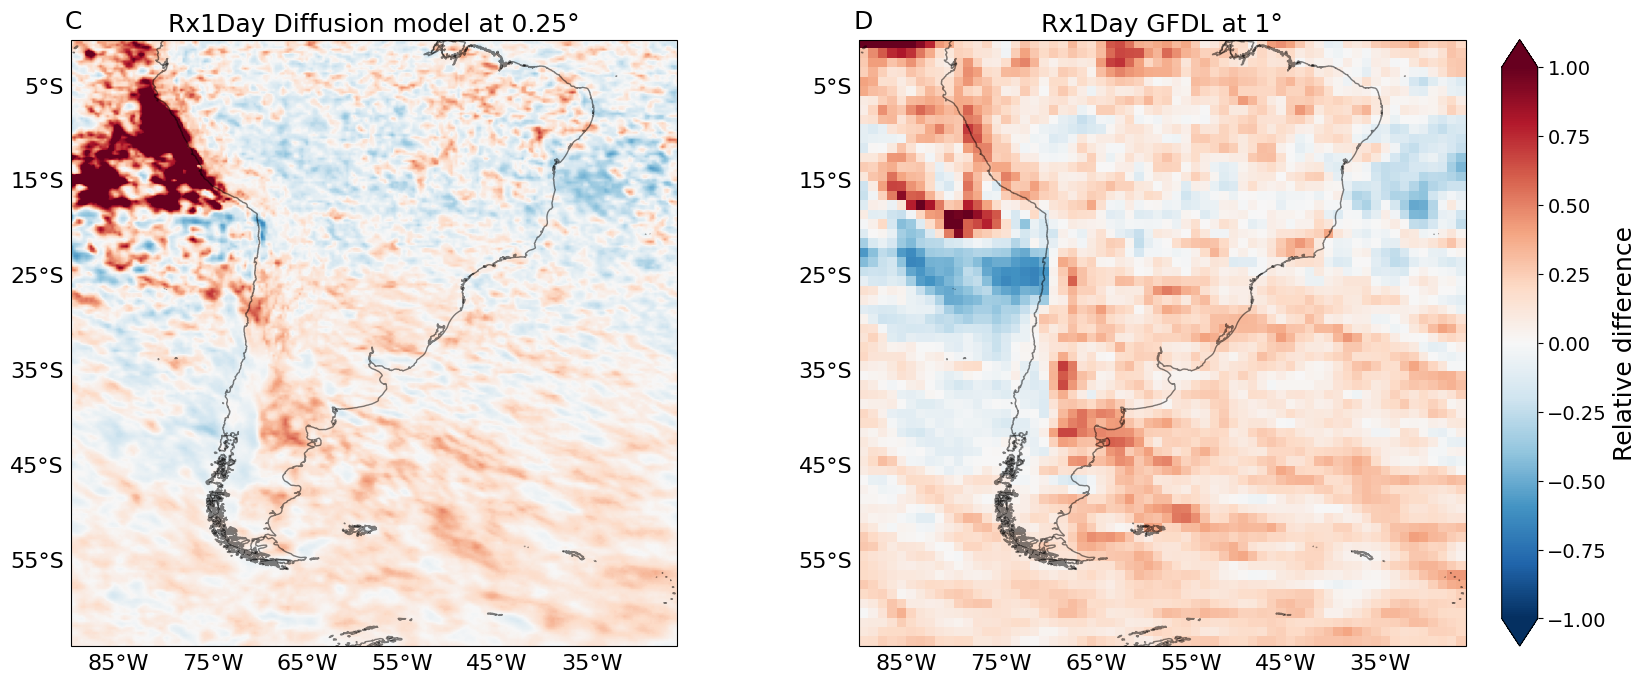

In [21]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs


def plot_precipitation(ax, data, title, min_value=3, max_value=3):
    cmap = 'RdBu_r' #,  "seismic" 
    norm = plt.Normalize(vmin=min_value, vmax=max_value)
    img = ax.imshow(data, cmap , norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img
    
latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.3, hspace=0.3)

max_value = 1
min_value = -1



img1 = plot_precipitation(axes[0],dm_rel_change, f'', min_value, max_value)
axes[0].text(-0.01, 1.05, 'C', transform=axes[0].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'A'
axes[0].set_title(f'Rx1Day Diffusion model at 0.25°', fontsize=18)

img2 = plot_precipitation(axes[1], gfdl_rel_change, f'', min_value,  max_value)
axes[1].text(-0.01, 1.05, 'D', transform=axes[1].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'B'
axes[1].set_title(f'Rx1Day GFDL at 1°', fontsize=18)


# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

    
# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height]) 
cbar = fig.colorbar(img1, cax=cbar_ax,  orientation="vertical",extend="both")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Relative difference', fontsize=18)

save_figu = False
if save_figu:
    plt.savefig("figures_paper/climate_change_signal_Rx1Day.pdf")
    print("Saving to figures_paper/climate_change_signal_Rx1Day.pdf")

plt.show()